In [1]:
import json
import os
import sys
import numpy as np
#np.random.seed(8888) #0.4700 private
#np.random.seed(12345) #0.4709 private
#np.random.seed(8889) #0.4718 private
np.random.seed(6666) #0.46948 private, 0.47221 public
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D,Conv1D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten
from keras.layers.pooling import GlobalMaxPooling2D,GlobalMaxPooling1D
from keras.models import Model,Sequential
from keras.layers.advanced_activations import PReLU
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


In [2]:
from keras import __version__ as keras_version
print('Keras version: {}'.format(keras_version))

Keras version: 2.0.3


In [3]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec.model'
vocab_path='model/word2vec_vocab.json'
embeddings_path='model/embeddings.npz'
#full_features_filename = '../data/features_full_plusnouns_pluspuidthreshpluss2vsimscore.csv'
full_features_filename = '../data/features_doc2vec_sense2vec_20170416.csv'


In [4]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [5]:
feature_df = reader.getBasicDataFrame(full_features_filename)

In [6]:
feature_df.columns

Index(['id', 'product_idx', 'product_uid', 'relevance', 'relevance_int',
       'search_term', 'color_exist', 'color1hot_almond', 'color1hot_aluminum',
       'color1hot_beige',
       ...
       'bm25brand', 'len_product_title', 'len_product_description',
       'len_brand', 'len_search_term', 'sense2vec_all_simscore',
       'sense2vec_keeptag_simscore', 'sense2vec_uidfact_all_simscore',
       'sense2vec_uidfact_keeptag_simscore', 'product_uid_threshold'],
      dtype='object', length=101)

In [7]:
feature_df.shape

(240760, 101)

In [8]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,...,bm25brand,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,0,0,...,0.000596,6,102,3,2,0.026117,-0.022627,0.026117,-0.022627,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,0,0,...,0.000000,6,102,3,2,0.159208,0.084537,0.159208,0.084537,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,0,0,...,0.000526,12,128,4,1,0.396952,0.110782,0.396952,0.110782,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,0,0,...,0.001148,11,78,1,3,0.305971,0.155425,0.305971,0.155425,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,0,0,...,0.000000,11,78,1,2,0.359548,0.149469,0.359548,0.149469,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,0,0,...,0.001613,12,346,1,2,0.012246,0.007444,0.012246,0.007444,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,0,0,...,0.000000,12,346,1,2,0.450305,0.152107,0.450305,0.152107,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,0,0,...,0.000000,12,346,1,1,0.382512,0.176739,0.382512,0.176739,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,0,0,...,0.000783,10,103,2,2,0.236343,0.094054,0.236343,0.094054,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,0,0,...,0.001093,14,60,3,3,0.355857,0.149728,0.355857,0.149728,1


In [9]:
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
print(soln_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 3 columns):
id           166693 non-null int64
relevance    166693 non-null float64
Usage        166693 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.8+ MB
None


In [10]:
dp = DataPreprocessing()
feature_test_df=feature_df.copy()
feature_test_df.pop('relevance')
test_private_df = dp.getGoldTestSet(feature_test_df, soln_df,
                                    testsetoption='Public')  # ,savepath='../data/test_private_gold.csv')

In [11]:
test_private_df

,id,product_idx,product_uid,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,color1hot_biscuit,...,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold,relevance
74068,4,"Int64Index([0], dtype='int64')",100001,NaN,metal l bracket,0,0,0,0,0,...,6,102,3,3,-0.013432,-0.007869,-0.013432,-0.007869,1,2.33
74071,7,"Int64Index([0], dtype='int64')",100001,NaN,simpson strong tie hcc668,0,0,0,0,0,...,6,102,3,4,0.101048,0.077886,0.101048,0.077886,1,2.00
74075,12,"Int64Index([54667], dtype='int64')",100003,NaN,one piec tub shower,0,0,0,0,0,...,21,79,1,4,0.294785,0.119400,0.294785,0.119400,1,2.00
74076,13,"Int64Index([54668], dtype='int64')",100004,NaN,solar panel,0,0,0,0,0,...,9,102,2,2,0.268002,0.163241,0.268002,0.163241,1,3.00
74077,14,"Int64Index([2], dtype='int64')",100005,NaN,1 handl shower delta trim kit,0,0,0,0,0,...,11,78,1,6,0.297397,0.108830,0.297397,0.108830,1,2.00
74082,25,"Int64Index([5], dtype='int64')",100009,NaN,3 1 20door case,0,0,0,0,0,...,14,60,3,4,0.217235,0.102798,0.217235,0.102798,1,2.33
74092,40,"Int64Index([7], dtype='int64')",100011,NaN,lawn mower,0,0,0,0,0,...,17,188,1,2,0.388901,0.226367,0.388901,0.226367,1,3.00
74097,45,"Int64Index([7], dtype='int64')",100011,NaN,toro lawn mower bag,0,0,0,0,0,...,17,188,1,4,0.023385,0.001151,0.023385,0.001151,1,2.67
74098,46,"Int64Index([7], dtype='int64')",100011,NaN,toro mower washout,0,0,0,0,0,...,17,188,1,3,0.014796,0.001652,0.014796,0.001652,1,2.67
74102,52,"Int64Index([9], dtype='int64')",100013,NaN,garbag dispos,0,0,0,0,0,...,8,67,1,2,0.035256,0.020145,0.035256,0.020145,1,2.00


In [12]:
feature_df.loc[feature_df.id.isin(test_private_df.id), ['relevance']] = test_private_df[['relevance']]


In [13]:
feature_df

,id,product_idx,product_uid,relevance,relevance_int,search_term,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,...,bm25brand,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold
0,2,"Int64Index([0], dtype='int64')",100001,3.00,12.0,angl bracket,0,0,0,0,...,0.000596,6,102,3,2,0.026117,-0.022627,0.026117,-0.022627,1
1,3,"Int64Index([0], dtype='int64')",100001,2.50,9.0,l bracket,0,0,0,0,...,0.000000,6,102,3,2,0.159208,0.084537,0.159208,0.084537,1
2,9,"Int64Index([1], dtype='int64')",100002,3.00,12.0,deck,0,0,0,0,...,0.000526,12,128,4,1,0.396952,0.110782,0.396952,0.110782,1
3,16,"Int64Index([2], dtype='int64')",100005,2.33,8.0,rain shower head,0,0,0,0,...,0.001148,11,78,1,3,0.305971,0.155425,0.305971,0.155425,1
4,17,"Int64Index([2], dtype='int64')",100005,2.67,10.0,shower faucet,0,0,0,0,...,0.000000,11,78,1,2,0.359548,0.149469,0.359548,0.149469,1
5,18,"Int64Index([3], dtype='int64')",100006,3.00,12.0,convect otr,0,0,0,0,...,0.001613,12,346,1,2,0.012246,0.007444,0.012246,0.007444,1
6,20,"Int64Index([3], dtype='int64')",100006,2.67,10.0,microwav stove,0,0,0,0,...,0.000000,12,346,1,2,0.450305,0.152107,0.450305,0.152107,1
7,21,"Int64Index([3], dtype='int64')",100006,3.00,12.0,microwav,0,0,0,0,...,0.000000,12,346,1,1,0.382512,0.176739,0.382512,0.176739,1
8,23,"Int64Index([4], dtype='int64')",100007,2.67,10.0,emerg light,0,0,0,0,...,0.000783,10,103,2,2,0.236343,0.094054,0.236343,0.094054,1
9,27,"Int64Index([5], dtype='int64')",100009,3.00,12.0,mdf 3 4,0,0,0,0,...,0.001093,14,60,3,3,0.355857,0.149728,0.355857,0.149728,1


In [14]:
# feature_rescale_df = feature_df[['relevance','sense2vec_all_simscore','sense2vec_keeptag_simscore',\
#                                  'sense2vec_uidfact_all_simscore','sense2vec_uidfact_keeptag_simscore',\
#                                  'product_uid_threshold'
#                                 ]].copy() 

feature_rescale_df = feature_df.copy() #feature_df[:74067].copy()
# # Must drop these columns for OrdinalRegression
feature_rescale_df.drop('id', axis=1, inplace=True)
feature_rescale_df.drop('search_term', axis=1, inplace=True)
feature_rescale_df.drop('product_uid', axis=1, inplace=True)
feature_rescale_df.drop('relevance_int', axis=1, inplace=True)
feature_rescale_df.drop('product_idx', axis=1, inplace=True)
feature_rescale_df.drop('Word2VecQueryExpansion', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_search_term_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_product_title_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_product_brand_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_product_description_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_attr_json_vector', axis=1, inplace=True)
# feature_rescale_df.drop('doc2vec_Word2VecQueryExpansion_vector', axis=1, inplace=True)


for feat in [# 'color1hot_almond', 'color1hot_aluminum',
#        'color1hot_beige', 'color1hot_biscuit', 'color1hot_bisque',
#        'color1hot_black', 'color1hot_blue', 'color1hot_bone',
#        'color1hot_brass', 'color1hot_bronze', 'color1hot_brown',
#        'color1hot_cedar', 'color1hot_charcoal', 'color1hot_cherry',
#        'color1hot_chestnut', 'color1hot_chocolate', 'color1hot_chrome',
#        'color1hot_clear', 'color1hot_color', 'color1hot_concrete',
#        'color1hot_copper', 'color1hot_cream', 'color1hot_daylight',
#        'color1hot_espresso', 'color1hot_gold', 'color1hot_gray',
#        'color1hot_green', 'color1hot_grey', 'color1hot_ivory',
#        'color1hot_java', 'color1hot_linen', 'color1hot_mahogany',
#        'color1hot_metallic', 'color1hot_mocha', 'color1hot_multi',
#        'color1hot_natural', 'color1hot_nickel', 'color1hot_oak',
#        'color1hot_orange', 'color1hot_pewter', 'color1hot_pink',
#        'color1hot_platinum', 'color1hot_primed', 'color1hot_purple',
#        'color1hot_red', 'color1hot_sand', 'color1hot_silver',
#        'color1hot_slate', 'color1hot_stainless', 'color1hot_steel',
#        'color1hot_tan', 'color1hot_taupe', 'color1hot_teal',
#        'color1hot_unfinished', 'color1hot_walnut', 'color1hot_white',
#        'color1hot_wood', 'color1hot_yellow',
    'wm_product_description',
       'wm_product_title', 'wm_product_brand', 'wm_attr_json']:
    feature_rescale_df.drop(feat, axis=1, inplace=True)
    

In [15]:
feature_rescale_df.columns

Index(['relevance', 'color_exist', 'color1hot_almond', 'color1hot_aluminum',
       'color1hot_beige', 'color1hot_biscuit', 'color1hot_bisque',
       'color1hot_black', 'color1hot_blue', 'color1hot_bone',
       'color1hot_brass', 'color1hot_bronze', 'color1hot_brown',
       'color1hot_cedar', 'color1hot_charcoal', 'color1hot_cherry',
       'color1hot_chestnut', 'color1hot_chocolate', 'color1hot_chrome',
       'color1hot_clear', 'color1hot_color', 'color1hot_concrete',
       'color1hot_copper', 'color1hot_cream', 'color1hot_daylight',
       'color1hot_espresso', 'color1hot_gold', 'color1hot_gray',
       'color1hot_green', 'color1hot_grey', 'color1hot_ivory',
       'color1hot_java', 'color1hot_linen', 'color1hot_mahogany',
       'color1hot_metallic', 'color1hot_mocha', 'color1hot_multi',
       'color1hot_natural', 'color1hot_nickel', 'color1hot_oak',
       'color1hot_orange', 'color1hot_pewter', 'color1hot_pink',
       'color1hot_platinum', 'color1hot_primed', 'color1hot_pur

In [16]:
feature_rescale_df

,relevance,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,color1hot_biscuit,color1hot_bisque,color1hot_black,color1hot_blue,color1hot_bone,...,bm25brand,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold
0,3.00,0,0,0,0,0,0,0,0,0,...,0.000596,6,102,3,2,0.026117,-0.022627,0.026117,-0.022627,1
1,2.50,0,0,0,0,0,0,0,0,0,...,0.000000,6,102,3,2,0.159208,0.084537,0.159208,0.084537,1
2,3.00,0,0,0,0,0,0,0,0,0,...,0.000526,12,128,4,1,0.396952,0.110782,0.396952,0.110782,1
3,2.33,0,0,0,0,0,0,0,0,0,...,0.001148,11,78,1,3,0.305971,0.155425,0.305971,0.155425,1
4,2.67,0,0,0,0,0,0,0,0,0,...,0.000000,11,78,1,2,0.359548,0.149469,0.359548,0.149469,1
5,3.00,0,0,0,0,0,0,0,0,0,...,0.001613,12,346,1,2,0.012246,0.007444,0.012246,0.007444,1
6,2.67,0,0,0,0,0,0,0,0,0,...,0.000000,12,346,1,2,0.450305,0.152107,0.450305,0.152107,1
7,3.00,0,0,0,0,0,0,0,0,0,...,0.000000,12,346,1,1,0.382512,0.176739,0.382512,0.176739,1
8,2.67,0,0,0,0,0,0,0,0,0,...,0.000783,10,103,2,2,0.236343,0.094054,0.236343,0.094054,1
9,3.00,0,0,0,0,0,0,0,0,0,...,0.001093,14,60,3,3,0.355857,0.149728,0.355857,0.149728,1


# Rescale values

In [17]:
feature_rescale_df=feature_rescale_df.replace([np.inf, -np.inf], np.nan)
feature_rescale_df=feature_rescale_df.replace([np.inf, -np.inf], np.nan).dropna()

In [18]:
feature_rescale_df

,relevance,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,color1hot_biscuit,color1hot_bisque,color1hot_black,color1hot_blue,color1hot_bone,...,bm25brand,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold
0,3.00,0,0,0,0,0,0,0,0,0,...,0.000596,6,102,3,2,0.026117,-0.022627,0.026117,-0.022627,1
1,2.50,0,0,0,0,0,0,0,0,0,...,0.000000,6,102,3,2,0.159208,0.084537,0.159208,0.084537,1
2,3.00,0,0,0,0,0,0,0,0,0,...,0.000526,12,128,4,1,0.396952,0.110782,0.396952,0.110782,1
3,2.33,0,0,0,0,0,0,0,0,0,...,0.001148,11,78,1,3,0.305971,0.155425,0.305971,0.155425,1
4,2.67,0,0,0,0,0,0,0,0,0,...,0.000000,11,78,1,2,0.359548,0.149469,0.359548,0.149469,1
5,3.00,0,0,0,0,0,0,0,0,0,...,0.001613,12,346,1,2,0.012246,0.007444,0.012246,0.007444,1
6,2.67,0,0,0,0,0,0,0,0,0,...,0.000000,12,346,1,2,0.450305,0.152107,0.450305,0.152107,1
7,3.00,0,0,0,0,0,0,0,0,0,...,0.000000,12,346,1,1,0.382512,0.176739,0.382512,0.176739,1
8,2.67,0,0,0,0,0,0,0,0,0,...,0.000783,10,103,2,2,0.236343,0.094054,0.236343,0.094054,1
9,3.00,0,0,0,0,0,0,0,0,0,...,0.001093,14,60,3,3,0.355857,0.149728,0.355857,0.149728,1


In [19]:
#https://www.quora.com/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together
def rescale_bounded_cont_feat(x,xmax,xmin):
    x_new = (2*x-xmax-xmin)/(xmax-xmin)
    return x_new

def rescale_cont_feat(x,xmean,xstd):
    x_new = (x-xmean)/xstd
    return x_new

for col in feature_rescale_df.columns:
    print("==== {}".format(col))
    if len(feature_rescale_df[col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[col].value_counts()) == 2:
        print('binary')
    else:
#         if col == 'relevance':
#             print('leave relevance')                     
        print(len(feature_rescale_df[col].value_counts()))
        print(feature_rescale_df[col].describe())
#         feature_rescale_df[col]=feature_rescale_df[col].apply(rescale_cont_feat, \
#                                       args=(feature_rescale_df[col].mean(),feature_rescale_df[col].std()))
        feature_rescale_df[col]=feature_rescale_df[col].apply(rescale_bounded_cont_feat, \
                                      args=(feature_rescale_df[col].max(),feature_rescale_df[col].min()))
##         if np.isinf(feature_rescale_df[col].max()):
##             print("is max inf")

==== relevance
13
count    107715.000000
mean          2.380585
std           0.534488
min           1.000000
25%           2.000000
50%           2.330000
75%           3.000000
max           3.000000
Name: relevance, dtype: float64
==== color_exist
binary
==== color1hot_almond
binary
==== color1hot_aluminum
binary
==== color1hot_beige
binary
==== color1hot_biscuit
binary
==== color1hot_bisque
binary
==== color1hot_black
binary
==== color1hot_blue
binary
==== color1hot_bone
binary
==== color1hot_brass
binary
==== color1hot_bronze
binary
==== color1hot_brown
binary
==== color1hot_cedar
binary
==== color1hot_charcoal
binary
==== color1hot_cherry
binary
==== color1hot_chestnut
binary
==== color1hot_chocolate
binary
==== color1hot_chrome
binary
==== color1hot_clear
binary
==== color1hot_color
binary
==== color1hot_concrete
binary
==== color1hot_copper
binary
==== color1hot_cream
binary
==== color1hot_daylight
binary
==== color1hot_espresso
binary
==== color1hot_gold
binary
==== color1hot_

In [20]:
for col in feature_rescale_df.columns:
    print("==== {}".format(col))
    if len(feature_rescale_df[col].value_counts()) == 1:
        print('pointless')
    elif len(feature_rescale_df[col].value_counts()) == 2:
        print('binary')
    else:
        if col == 'relevance':
            print('leave relevance')                     
        print(len(feature_rescale_df[col].value_counts()))
        print(feature_rescale_df[col].describe())

==== relevance
leave relevance
13
count    107715.000000
mean          0.380585
std           0.534488
min          -1.000000
25%           0.000000
50%           0.330000
75%           1.000000
max           1.000000
Name: relevance, dtype: float64
==== color_exist
binary
==== color1hot_almond
binary
==== color1hot_aluminum
binary
==== color1hot_beige
binary
==== color1hot_biscuit
binary
==== color1hot_bisque
binary
==== color1hot_black
binary
==== color1hot_blue
binary
==== color1hot_bone
binary
==== color1hot_brass
binary
==== color1hot_bronze
binary
==== color1hot_brown
binary
==== color1hot_cedar
binary
==== color1hot_charcoal
binary
==== color1hot_cherry
binary
==== color1hot_chestnut
binary
==== color1hot_chocolate
binary
==== color1hot_chrome
binary
==== color1hot_clear
binary
==== color1hot_color
binary
==== color1hot_concrete
binary
==== color1hot_copper
binary
==== color1hot_cream
binary
==== color1hot_daylight
binary
==== color1hot_espresso
binary
==== color1hot_gold
binary

In [21]:
feature_rescale_df

,relevance,color_exist,color1hot_almond,color1hot_aluminum,color1hot_beige,color1hot_biscuit,color1hot_bisque,color1hot_black,color1hot_blue,color1hot_bone,...,bm25brand,len_product_title,len_product_description,len_brand,len_search_term,sense2vec_all_simscore,sense2vec_keeptag_simscore,sense2vec_uidfact_all_simscore,sense2vec_uidfact_keeptag_simscore,product_uid_threshold
0,1.00,0,0,0,0,0,0,0,0,0,...,-0.869178,-0.696970,-0.791967,-0.2,-0.764706,-0.322377,-0.559686,-0.274847,-0.491082,1
1,0.50,0,0,0,0,0,0,0,0,0,...,-1.000000,-0.696970,-0.791967,-0.2,-0.764706,-0.014425,-0.265570,0.054707,-0.151140,1
2,1.00,0,0,0,0,0,0,0,0,0,...,-0.884486,-0.333333,-0.738414,0.2,-0.882353,0.535681,-0.193540,0.643399,-0.067887,1
3,0.33,0,0,0,0,0,0,0,0,0,...,-0.748109,-0.393939,-0.841401,-1.0,-0.647059,0.325165,-0.071014,0.418117,0.073730,1
4,0.67,0,0,0,0,0,0,0,0,0,...,-1.000000,-0.393939,-0.841401,-1.0,-0.764706,0.449134,-0.087361,0.550781,0.054836,1
5,1.00,0,0,0,0,0,0,0,0,0,...,-0.646129,-0.333333,-0.289392,-1.0,-0.764706,-0.354472,-0.477154,-0.309192,-0.395690,1
6,0.67,0,0,0,0,0,0,0,0,0,...,-1.000000,-0.333333,-0.289392,-1.0,-0.764706,0.659132,-0.080119,0.775509,0.063206,1
7,1.00,0,0,0,0,0,0,0,0,0,...,-1.000000,-0.333333,-0.289392,-1.0,-0.882353,0.502269,-0.012517,0.607643,0.141341,1
8,0.67,0,0,0,0,0,0,0,0,0,...,-0.828157,-0.454545,-0.789907,-0.6,-0.764706,0.164054,-0.239448,0.245705,-0.120948,1
9,1.00,0,0,0,0,0,0,0,0,0,...,-0.760198,-0.212121,-0.878476,-0.2,-0.647059,0.440594,-0.086649,0.541642,0.055658,1


# input to model

In [22]:
feature_all_train_df = feature_rescale_df[:74067]
feature_test_df = feature_rescale_df[74067:]

In [23]:
feature_test_df.shape

(33648, 91)

In [24]:
# take 0.2 for validation
min_train_samples=int(len(feature_all_train_df)*0.8)
feature_train_df = feature_all_train_df.ix[np.random.choice(feature_all_train_df.index,min_train_samples,replace=False)]
feature_val_df = feature_all_train_df.ix[feature_all_train_df.index.difference(feature_train_df.index)]

In [25]:
print(len(feature_train_df))
print(len(feature_val_df))

59253
14814


In [26]:
y_train=feature_train_df['relevance'].as_matrix()
y_val=feature_val_df['relevance'].as_matrix()
y_test=feature_test_df['relevance'].as_matrix()

In [27]:
x_train=feature_train_df.drop('relevance', axis=1, inplace=False).as_matrix()
x_val=feature_val_df.drop('relevance', axis=1, inplace=False).as_matrix()
x_test=feature_test_df.drop('relevance', axis=1, inplace=False).as_matrix()

In [28]:
# #for conv1d
# x_train = np.expand_dims(x_train, axis=1)
# x_val = np.expand_dims(x_val, axis=1)
# x_test = np.expand_dims(x_test, axis=1)

In [29]:
x_train.shape

(59253, 90)

In [30]:
rowcnt=0
for row in x_train:
    if np.isnan(np.max(row)):
        print(rowcnt)
    rowcnt+=1

In [31]:
x_train[70]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0795578 , -1.        , -0.40801391, -1.        ,  0.0795578 ,
       -1.        , -0.42595823, -1.        ,  0.45317635,  0.28

In [32]:
feature_train_df.iloc[70]

relevance                               0.330000
color_exist                             0.000000
color1hot_almond                        0.000000
color1hot_aluminum                      0.000000
color1hot_beige                         0.000000
color1hot_biscuit                       0.000000
color1hot_bisque                        0.000000
color1hot_black                         0.000000
color1hot_blue                          0.000000
color1hot_bone                          0.000000
color1hot_brass                         0.000000
color1hot_bronze                        0.000000
color1hot_brown                         0.000000
color1hot_cedar                         0.000000
color1hot_charcoal                      0.000000
color1hot_cherry                        0.000000
color1hot_chestnut                      0.000000
color1hot_chocolate                     0.000000
color1hot_chrome                        0.000000
color1hot_clear                         0.000000
color1hot_color     

# define model


In [33]:
print('Building model...')
model = Sequential()
# model.add(Conv1D(filters=512,
#                         kernel_size=1,#6,
#                         padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
#                         activation='relu',
#                         input_shape=(1, x_train.shape[2]),
#                         kernel_initializer='lecun_uniform'
#                         # lecun_uniform for both gets AUC: 0.865961 | (good split) AUC: 0.861570 with avg pool at end
#                         # glorot_uniform for both gets AUC: 0.868817 | AUC: 0.863290  with avg pool at end
#                         # he_uniform for both gets AUC: 0.868218 | AUC: 0.873585 with avg pool at end
#                         ))

# model.add(GlobalMaxPooling1D())

## dense
# #model.add(Dense(128,activation='relu',batch_input_shape=(None,x_train.shape[1])))
# model.add(Dense(128,batch_input_shape=(None,x_train.shape[1]), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# model.add(Dropout(0.1))

## dense
#model.add(Dense(64,activation='relu'))#,batch_input_shape=(None,x_train.shape[1])))
model.add(Dense(256,
                batch_input_shape=(None,x_train.shape[1]), 
                activation='relu', 
                use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#model.add(PReLU(init='zero', weights=None))
model.add(Dropout(0.2))

# ## dense
# #model.add(Dense(64,activation='relu'))
# model.add(Dense(256, 
#                 activation='relu', 
#                 use_bias=True, kernel_initializer='glorot_uniform', \
#                bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
# #model.add(PReLU(init='zero', weights=None))
# model.add(Dropout(0.2))

## dense
#model.add(Dense(64,activation='relu'))
model.add(Dense(256, 
                activation='relu', 
                use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#model.add(PReLU(init='zero', weights=None))
model.add(Dropout(0.2))

## dense
#activation='linear',
model.add(Dense(1, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', \
               bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

model.summary()

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               23296     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 89,345
Trainable params: 89,345
Non-trainable params: 0
_________________________________________________________________


In [34]:
optimizer = optimizers.Adam(lr=0.0001)
#optimizer = optimizers.adadelta()
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
batch_size=64#2 #200
model_fn='./model/dnn3.h5'
# model_config_filepath='./model/cnn.json'
# with open(model_config_filepath,'w') as f:
#     json.dump(model.to_json(),f)

print('Train...')
ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
                       save_best_only=True, save_weights_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
hist=model.fit([x_train], [y_train],
          batch_size=batch_size,
          epochs=40,
          shuffle=True,
          verbose=2,
          #validation_split=0.2,
          validation_data=([x_val],y_val),
          callbacks=[ckpt,earlystopper],
         )

Train...
Train on 59253 samples, validate on 14814 samples
Epoch 1/40
Epoch 00000: val_loss improved from inf to 0.22608, saving model to ./model/dnn3.h5
3s - loss: 0.2464 - acc: 0.2759 - val_loss: 0.2261 - val_acc: 0.2946
Epoch 2/40
Epoch 00001: val_loss improved from 0.22608 to 0.22286, saving model to ./model/dnn3.h5
3s - loss: 0.2299 - acc: 0.2928 - val_loss: 0.2229 - val_acc: 0.2905
Epoch 3/40
Epoch 00002: val_loss improved from 0.22286 to 0.22137, saving model to ./model/dnn3.h5
3s - loss: 0.2273 - acc: 0.2933 - val_loss: 0.2214 - val_acc: 0.2928
Epoch 4/40
Epoch 00003: val_loss did not improve
2s - loss: 0.2250 - acc: 0.2952 - val_loss: 0.2215 - val_acc: 0.2955
Epoch 5/40
Epoch 00004: val_loss improved from 0.22137 to 0.22038, saving model to ./model/dnn3.h5
3s - loss: 0.2237 - acc: 0.2958 - val_loss: 0.2204 - val_acc: 0.2945
Epoch 6/40
Epoch 00005: val_loss improved from 0.22038 to 0.22005, saving model to ./model/dnn3.h5
3s - loss: 0.2230 - acc: 0.2964 - val_loss: 0.2201 - val

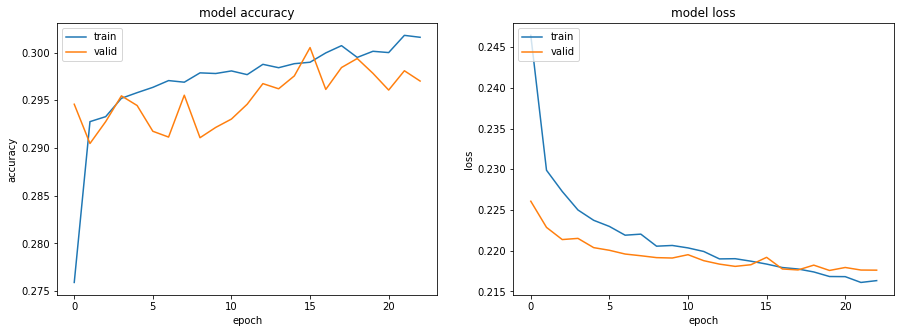

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [37]:
print("== Reload to best weights saved...")
model.load_weights(model_fn)

== Reload to best weights saved...


In [38]:
batch_size=64 #200
prediction=model.predict([x_train],
          batch_size=batch_size,
         )

In [39]:
np.max(prediction)

0.89203745

In [40]:
np.min(prediction)

-0.42779103

In [41]:
np.max(y_train)

1.0

In [42]:
np.min(y_train)

-1.0

In [43]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_train, prediction)**0.5
print(RMSE)

0.461966220019


In [44]:
#prediction_ori_scale=(prediction*2)+1 # to 0-1
prediction_ori_scale = prediction+2
gold_ori_scale = y_train+2
RMSE = mean_squared_error(gold_ori_scale, prediction_ori_scale)**0.5
print(RMSE)

0.461966219514


In [45]:
np.min(gold_ori_scale)

1.0

# Predict

In [46]:
batch_size=64 #200
test_prediction=model.predict([x_test],
          batch_size=batch_size,
         )

In [47]:
RMSE = mean_squared_error(y_test, test_prediction)**0.5
print(RMSE)

0.472106575358


In [48]:
#prediction_ori_scale=(prediction*2)+1 # to 0-1
test_prediction_ori_scale = test_prediction+2
test_gold_ori_scale = y_test+2
RMSE = mean_squared_error(test_gold_ori_scale, test_prediction_ori_scale)**0.5
print(RMSE)

0.472106575935


In [49]:
#0.4715 best with conv1d
#0.4739 best with full spec dense only 2x 64 hdim, 0.1 dropuot
#0.4730 best with full spec dense only 3x 64 hdim, 0.1 dropuot
#0.4725 best with full spec dense only 1x128 , 3x 64 hdim, 0.1 dropuot
#0.4737 best with full spec dense only 1x128 , 2x 64 hdim, 0.1 dropuot
#0.4737 best with full spec dense only 1x20 , 1x 10 hdim, 0.1 dropuot
#0.4741 best with full spec dense only 1x20 , 1x 10 hdim, 0.1 dropuot


In [50]:
#0.4711 with sense2vec conv1d
#0.4699 with sense2vec dnn
#0.4699 with sense2vec dnn minus onehot

# test private

In [51]:
test_private_pred_df = pd.DataFrame(test_private_df.id)
test_private_pred_df.reset_index(drop=True, inplace=True)

In [52]:
test_prediction_ori_scale_df = pd.DataFrame(test_prediction_ori_scale,columns=['pred_relevance'])
test_prediction_ori_scale_df

,pred_relevance
0,2.026729
1,2.363501
2,2.158385
3,2.683826
4,2.665392
5,2.168998
6,2.609033
7,2.583820
8,2.422823
9,2.432840


In [53]:
test_private_pred_df=test_private_pred_df.join(test_prediction_ori_scale_df)

In [54]:
test_private_pred_df

,id,pred_relevance
0,4,2.026729
1,7,2.363501
2,12,2.158385
3,13,2.683826
4,14,2.665392
5,25,2.168998
6,40,2.609033
7,45,2.583820
8,46,2.422823
9,52,2.432840


In [55]:
pd.DataFrame(test_private_pred_df).to_csv('../data/dnn_public_256_0.2drop_colorincl_run_20160418-2.csv', \
                                    index=False, header=True)